# CEWA-566: Satellite Remote Sensing for Water Resources

## Data Exploration in Google Earth Engine (contd..)

**Recap:**  
In Last Class, we talked about:

    1. Datasets in Earth Engine
    2. Earth Engine Image Collections
    3. How to explore dataset
    4. Reducing Datasets
    5. Writing custom functions to estimate variables from an image collection
    6. Understaning Computational/Coding Errors and Handling them in GEE. (Best Practices)
    
**Today:**  
In this class, we will learn about:

    1. Reducing Datasets regionally
    2. Features
    3. Feature Collections
    4. Comparing & manipulate Datasets
    5. Visualisation Tricks
    6. Exporting Images and Feature Collections

### Initialization

Today, we will use **geopandas** library to work with geodatframes and shapefiles in python. To install it, open terminal and follow the two steps:

1. ```conda activate ./.env```
2. ```mamba install geopandas```

In [ ]:
import ee
import numpy as np
import geemap
import pandas as pd
import datetime
import geemap.colormaps as cm

# To read and use shapefiles
import geopandas as gpd
# To plot graphs and maps: for visualisation
import matplotlib.pyplot as plt

In [ ]:
#ee.Authenticate()  # Only run for the first time or if ee.Initialize() does not work.

In [ ]:
ee.Initialize()        

### Functions to calculate Daily Precipitation for a given duration

In [ ]:
def total_daily_precip(date, image_collection, freq, band):
    """This function calculates an earth engine image of daily precipitation for a given date in mm/day.

    Parameters
    ----------
    date : datetime64[ns]
        The date for which total daily precipitation needs to be calculated.
    image_collection : ee.imagecollection
        An ee.image collection object containing the precipitation data in mm/hr at a constant frequency. This collection should contain (not exclusively)
        all the images for the date provided.
    freq: float
        The hourly frequency of observed precipitation images in the provided image collection.
    band: string
        The name of the band that will be used to estimate daily precipitation.
        
    Returns
    -------
    ee.image
        an ee.image object representing the daily precipitation in mm/day for a given date.
    """
    ## Getting only date from the timestamp
    date = date.date()
    
    ## Calculating end date
    end_date = date + datetime.timedelta(days=1)
    
    ## Filtering image collection & selecting the particular band. Please note that filterDate method only accepts dates as string.
    day_filtered_collection = image_collection.filterDate(str(date),str(end_date)).select(band)
    
    ## Reducing image collection to a single image by calculating sum of total precipitation
    day_total_precipitation = day_filtered_collection.reduce(ee.Reducer.sum()).multiply(freq)
    
    ## Adding date to the metadata of the image
    # day_total_precipitation = day_total_precipitation.set({'system:time_start':day_filtered_collection.first().get('system:time_start')})
    day_total_precipitation = day_total_precipitation.set({'system:time_start':str(date)})
    
    ## Return the computed image
    return day_total_precipitation

Please note that we have changed the below function to accomodate computations over longer time periods by breaking computations into smaller chunks of 365 days as we did in last class.

In [ ]:
def create_daily_precip_collection(start_date,end_date,image_collection,freq,band):
    ''' Creates an earth engine image collection having the daily precipitation aggregates in mm/day for a given duration.
    
    Parameters
    ----------
    start_date : str
        The start date of the duration for which total daily precipitation needs to be calculated.
    end_date : str
        The end date of the duration for which total daily precipitation needs to be calculated.
    image_collection : ee.imagecollection
        An ee.image collection object containing the precipitation data in mm/hr at a constant frequency. This collection should contain (not exclusively)
        all the images for the date provided.
    freq: float
        The hourly frequency of observed precipitation images in the provided image collection.
    band: str
        The name of the band that will be used to estimate daily precipitation.
        
    Returns
    -------
    ee.ImageCollection
        an ee.ImageCollection object representing the daily precipitation in mm/day for a given duration.
    '''
    
    # Create a list of required dates
    dates_list = pd.date_range(start=start_date,end=end_date)
    
    ## Break the list into sections of 365 days by calculating number of chunks
    no_chunks = int(len(dates_list)/365)
    if no_chunks==0:
        dates_list_chunks = [dates_list]
    else:
        dates_list_chunks = np.array_split(dates_list, no_chunks)
    
    ## Creating an empty Image Collection to merge everything in
    daily_precip_collection_merged = ee.ImageCollection(ee.List([]))
    
    ## Adding another loop to compute daily precip images in a loop of 365 days
    for chunk in dates_list_chunks:

        # Create an empty earth engine list where we will collect all the daily images
        daily_precip_list = ee.List([])

        # Starting a loop for each date in the date list
        for date in chunk:
            # Apply the function to calculate daily precipitation in mm/day
            day_total_precipitation_image = total_daily_precip(date=date, image_collection=image_collection, freq=freq, band=band)
            # Add the returned image to the list to store it
            daily_precip_list = daily_precip_list.add(day_total_precipitation_image)

        # Create an image collection using the list
        daily_precip_collection = ee.ImageCollection(daily_precip_list)
        
        ## Merge this collection with the merged collection
        daily_precip_collection_merged = daily_precip_collection_merged.merge(daily_precip_collection)
    
    ## Change the returned collection to the one which is merged
    return daily_precip_collection_merged

#### Code from Previous Class

In [ ]:
# Creating an EE instance for Imerg data collection/dataset
gpm_collection = ee.ImageCollection("NASA/GPM_L3/IMERG_V06")

In [ ]:
# Computing the daily precipitation for a time duration 
daily_precip_collection_2021 = create_daily_precip_collection(start_date="2021-01-01",
            end_date="2021-12-31",image_collection=gpm_collection, freq=0.5, band='precipitationCal')

# Taking sum at each pixel from the stack of images (bandwise but we have only one band)
############## Complete the code ###############
annual_precip_2021 = 

In [ ]:
# Getting the rainbow color palette 
rainbow_palette = cm.palettes.rainbow

### Reducing an Image Collection

 Last time, we learnt how we can reduce image collections to a single image by taking examples of converting half-hourly precipitation to mean precipitation or aggregating to daily precipitation or taking a maximum at each pixel to get maximum observed precipitation.

**Now how can we reduce even that single image we have to useful information that we need?**

1. We can clip an image to a smaller region of interest.
2. We can calculate statistical parameters within the region of interest.

We can say it regional reduction in terms of 'GEE'.

### Regional Reduction of Image Collection

#### Clipping a reduced Image

Let's try to get Mean Observed Annual Precipitation only for Washington State for year 2021.

**Step-1** Read the shapefile using geopandas.

In [ ]:
# Variable to store path of file
path_to_shapefile = 'WA_State_Boundary/WA_State_Boundary.shp'
# Reading a shapefile using geopandas
washington_state_map = gpd.read_file(path_to_shapefile)
# Print Washington state
washington_state_map

In [ ]:
# Plotting a shapefile using geopandas method .plot()
washington_state_map.plot()

You can see the outline of Washington state. You might notice that our axis is not referring to latitude and longitude coordinates. This can be adjusted using the [Coordinate Reference System or CRS](https://geopandas.org/en/stable/docs/user_guide/projections.html). The most common CRS used is WGS84 lat/long projection.

In [ ]:
# Correcting the crs
washington_state_map = washington_state_map.to_crs(epsg=4326)

In [ ]:
# Plot the geometry
############## Complete the code ###############

plt.xlabel('Longitude')
plt.ylabel('Latitude');

#### Feature Collection

As Image collection contains raster data, Feature Collection can contain vector data. You can think of Feature Collection as dataframes where it can also include geodataframes.
Analogus to images we will have features. Please note that Feature or Image Collection can have one object.

Click here to know more about [Features and Feature Collection](https://developers.google.com/earth-engine/guides/features).

**Step-2** Convert the shapefile geopandas geometry object to earth engine geometry object or a feature. As feature will have geometry object and some attributes.

In [ ]:
# Convert Geopandas dataframe to FeatureCollection using one line of code
washington_ee_feature_collection = geemap.geopandas_to_ee(washington_state_map)

In [ ]:
# Getting the size of the feature collection
############## Complete the code ###############
print('The number of geometry features in the washington_ee_feature_collection: ',)


**Step-3** Clip the image with roi earth engine geometry object

In [ ]:
# Clip an image with geometry
############## Complete the code ###############
washington_obs_annual_precip = 

In [ ]:
geemap.image_props(washington_mean_obs_daily_precip).getInfo()

In [ ]:
# Creating an instance of map
Map = geemap.Map()

# Defining visualisation parameters for precipitation
Precip_Viz_params_daily = {'min': 0, 'max': 1600, 'palette': rainbow_palette}

# Adding the max observed precipitation image to the map
Map.addLayer(washington_obs_annual_precip, Precip_Viz_params_daily, "Mean Observed Precipitation from 2001-2022", opacity=0.7)

# Seeting center of map same as 
Map.setCenter(-120.7401, 47.7511, 6) # Seattle

# Adding colorbar
Map.add_colorbar(Precip_Viz_params_daily, label="Precipitation (mm/day)")

Map

#### Reducing Image to Feature /or/ Reducing Image Collection to Feature Collection

Suppose, we want to have a time series of mean daily precipitation for Washington State for the year 2022. 

**Step 1:** Create an image collection of daily precip for the year 2022.

In [ ]:
# Computing the daily precipitation for a duration 
daily_precip_collection_2022 = create_daily_precip_collection(start_date="2022-01-01",
            end_date="2022-12-31",image_collection=gpm_collection, freq=0.5, band='precipitationCal')

**Step 2:** Create a function to clip an image to a region of interest and reduce it to a mean. **To achieve this can we definitely use ee.Image.clip() and ee.Image.reduce()? If not, why?**
We can use ee.Image.reduceRegion(). It applies a reducer to all the pixels of the image in a specific region. To know more about this method click [here](https://developers.google.com/earth-engine/apidocs/ee-image-reduceregion).

In [ ]:
## To create a function first we will write a generalized piece of code for one image

# define input arguments 
image = daily_precip_collection_2022.first()
roi = washington_ee_feature_collection
scale = 111319.49
crs = 'EPSG:4326'

# Taking mean over region
mean_over_region = image.reduceRegion(
                          reducer= ee.Reducer.mean(),
                          geometry= roi,
                          scale= scale,
                          crs= crs,
                        );
# Getting the calculated value
mean_over_region.getInfo()

**Note:** it returns a dictionary and just the mean value (No date). Date should also be returned.

If we have to apply function to each image, we will have to use ```.map()```. Click [here](https://developers.google.com/earth-engine/apidocs/ee-imagecollection-map) to know about how to use this method. 

**So, what the function should return?** 

In [ ]:
############## Complete the code ###############
def reduce_region_function(image, roi, scale, crs):
    ''' Clips an earth engine image to a given region of interest (roi) and reduces it to a mean.
    
    Parameters
    ----------
    image : ee.Image
        An ee.Image object that will be used to compute mean over roi.
    roi: ee.Feature or ee.Geometry
        An ee.Feature or ee.Geometry representing the region of interest to which the image will be clipped
    
    Returns
    -------
    ee.Feature
        An ee.Feature representing the mean of the image over roi.
    '''
    # Taking mean over region
    
    
    # Preparing a dictionary of required properties
    property_dict={'date': image.get('system:time_start'),
            'daily_precip': mean_over_region.get('precipitationCal_sum')}
    
    return ee.Feature(None,property_dict)

**Step 3:** Apply the function to all images in the image collection.

In [ ]:
# Mapping the function to each image in the collection
daily_precip_collection_2022_washington = daily_precip_collection_2022.map(
            lambda image: reduce_region_function(image, washington_ee_feature_collection, 111319.49, 'EPSG:4326' ))

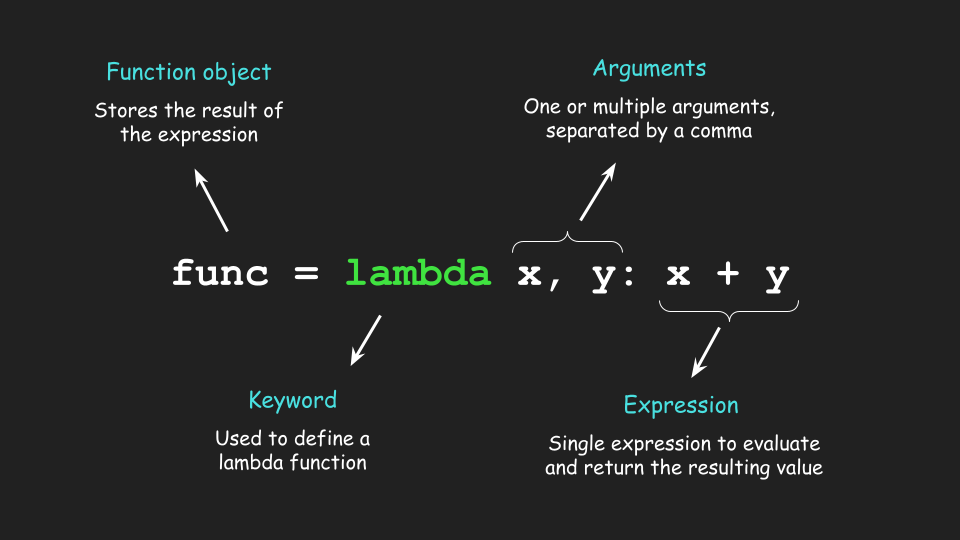

**Step 4:** Export the computed feature collection to client or local object.

In [ ]:
# Storing the output from earth-engine into a local object
daily_precip_ts = daily_precip_collection_2022_washington.getInfo()

Let's see what we got.

In [ ]:
## Re-run cell by uncommenting one by one and see the difference

daily_precip_ts
# daily_precip_ts['features']
# pd.DataFrame(daily_precip_ts['features'])
# daily_precip_df = pd.DataFrame(daily_precip_ts['features'])
# pd.json_normalize(df['properties'])
# daily_precip_df = pd.json_normalize(daily_precip_df['properties'])

In [ ]:
# Converting Dates to datetime object instead of strings
daily_precip_df['date']=pd.to_datetime(daily_precip_df['date'])
# Plotting Time Series Data
plt.figure(figsize=(10,5))
plt.plot(daily_precip_df['date'],daily_precip_df['daily_precip'])
plt.xlabel('Date')
plt.ylabel('Average Daily Precipitation (in mm)')
plt.title('Average Precipitation in the State of Washington')

Remember that as Washington state has very diverse climate, it makes little sense to calculate average precipitation for the whole state. But the same technique can be used to get average precipitation over Seattle or other smaller region.

### Homework-4B

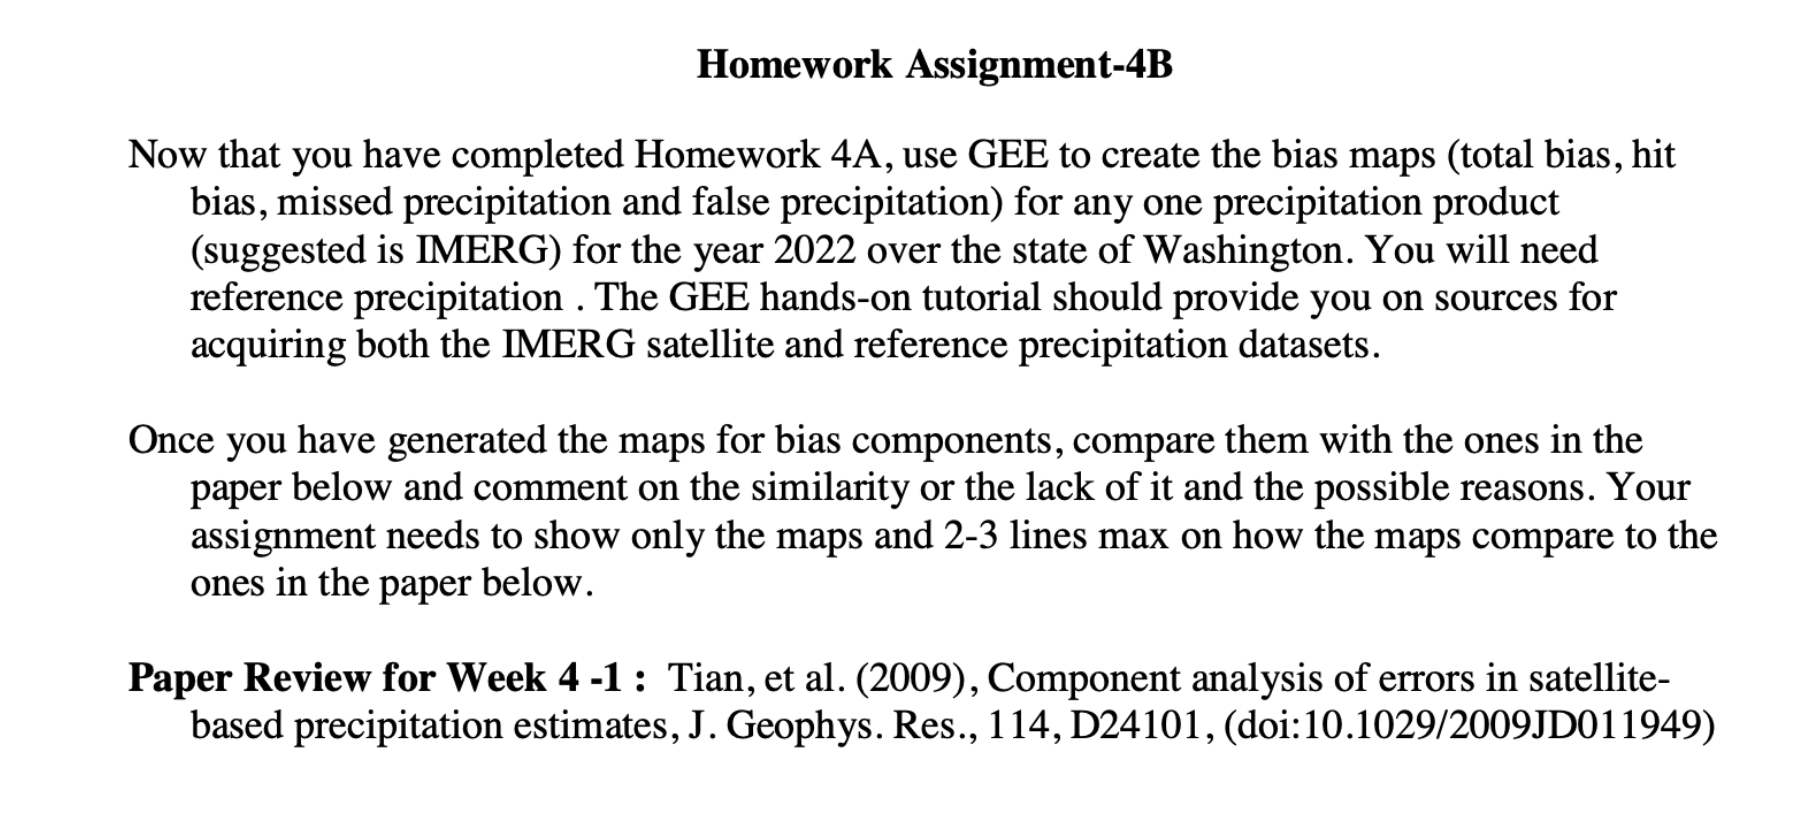

#### Solution:

To calculate Errors, we need reference Datasets. For this, we can use [ERA5 Daily Product](https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_DAILY_AGGR#bands). 

**Check the dataset and see what is the resolution, which band should we use and what are the units? Also look at the temporal resolution and the time duration for which data is available.**

**Step 1:** Load the datasets and only the band you need.

In [ ]:
# Loading the dataset and selecting the band
era5_collection = ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR").select('total_precipitation_sum')
gpm_collection_cal = ee.ImageCollection("NASA/GPM_L3/IMERG_V06").select('precipitationCal')


**Step 2:** Calculate daily precipitation for both for the year 2022. Remember the units.  
**Both datasets are in the same resolution. If the resolution would have been different, then?**

In [ ]:
# Filtering and computing daily precipitation
era5_collection_2022_daily = create_daily_precip_collection(start_date="2022-01-01",
            end_date="2022-12-31",image_collection=era5_collection, freq=1, band='total_precipitation_sum')

gpm_collection_cal_2022_daily = create_daily_precip_collection(start_date="2022-01-01",
            end_date="2022-12-31",image_collection=gpm_collection_cal, freq=0.5, band='precipitationCal')


**Step 3:** Clip each image of image collection to Washington State

In [ ]:
# Clipping each image of image collection to region of interest
era5_collection_2022_daily_wa = era5_collection_2022_daily.map(lambda image: image.clip(
            washington_ee_feature_collection))
gpm_collection_cal_2022_daily_wa = gpm_collection_cal_2022_daily.map(lambda image: image.clip(
            washington_ee_feature_collection))


Since we have to now compare two image collections, we cannot use map as map applies function to images of only one collection.  
**Step 4:** Combine both the image collections into single so that we have two compare two bands of an image rather than two images from different collections.
See ```ee.ImageCollection.combine()``` [here](https://developers.google.com/earth-engine/apidocs/ee-imagecollection-combine).

In [ ]:
# Combining two different collections on the basis of ID or index number
daily_precip_cal = gpm_collection_cal_2022_daily_wa.combine(era5_collection_2022_daily_wa)



In [ ]:
# Copying one variable to another
daily_precip = daily_precip_cal

In [ ]:
# Total size of the collection
daily_precip.size().getInfo()

In [ ]:
# Getting the properties of the first image of the collection
daily_precip.first().getInfo()

In [ ]:
# Renaming bands in the image collection
# daily_precip = daily_precip.select(['precipitationCal_sum','total_precipitation_sum_sum'],
#                                 ['estimated_precip','reference_precip'])

daily_precip = daily_precip.select(['IRprecipitation_sum','precipitationCal_sum'],
                                ['estimated_precip','reference_precip'])

In [ ]:
# Getting the properties of the first image of the collection
daily_precip.first().getInfo()

**Step 5:** Consider a single image from combined collection now. Try to find hit, miss and false precipitation. Then we can use the same code as a function to map it for all images.

In [ ]:
# Pick first image in the image collection
image = daily_precip.first()

**Step 6:** Create a precipitation event binary mask. 1 if precipitation occured and 0 if not. We can use a threshold of 1 mm/day to create the mask.

See ```Image.gt()``` method [here](https://developers.google.com/earth-engine/apidocs/ee-image-gt).

In [ ]:
# Defining threshold for yes/no precipitation event
threshold = 1
# Computing binary precipitation masks for estimated and reference bands 
estimated_precip_mask =  image.select('estimated_precip').gt(threshold)
reference_precip_mask = image.select('reference_precip').gt(threshold)                                                    

**Step 7:** Create a hit mask, miss precip mask and false precip mask using the above two precip masks. See ```Image.multiply()``` method [here](https://developers.google.com/earth-engine/apidocs/ee-image-multiply) and ```Image.not()``` method [here](https://developers.google.com/earth-engine/apidocs/ee-image-not).  

In [ ]:
# Computing hit, miss and false mask
hit_mask = estimated_precip_mask.multiply(reference_precip_mask)
miss_mask = estimated_precip_mask.Not().multiply(reference_precip_mask)
false_mask = estimated_precip_mask.multiply(reference_precip_mask.Not())

**Step 8:** Calculate total error by substracting reference precipitation from estimated precipitation.

In [ ]:
# Computing total error
image = image.addBands(image.select('estimated_precip')
                            .subtract(image.select('reference_precip')
                                           .multiply(1000))
                            .rename('total_error'))

In [ ]:
geemap.image_props(image).getInfo()

**Step 9:** Calculate hit precip, miss precip and false precip simply by multiplying total error with different masks as all these masks are inependent of each other.

In [ ]:
# Computing hit error, miss precip and false precip and adding it as bands 
image = image.addBands(image.select('total_error')
                            .multiply(hit_mask)
                            .rename('hit_error'))

image = image.addBands(image.select('total_error')
                            .multiply(miss_mask)
                            .rename('miss_precip'))

image = image.addBands(image.select('total_error')
                            .multiply(false_mask)
                            .rename('false_precip'))

In [ ]:
geemap.image_props(image).getInfo()

In [ ]:
# Getting the color palettes 
hit_palette = cm.palettes.PuOr
miss_palette = cm.palettes.Blues_r
false_palette = cm.palettes.Reds

# Creating an instance of map
Map = geemap.Map()

# Defining visualisation parameters for errors
hit_Viz_params = {'min': -25, 'max': 25, 'palette': hit_palette}
miss_Viz_params = {'min': -50, 'max': 0, 'palette': miss_palette}
false_Viz_params = {'min': 0, 'max': 50, 'palette': false_palette}

# Adding the image bands to the map
Map.addLayer(image.select('hit_error'), hit_Viz_params, "Hit Error", opacity=1.0)
Map.addLayer(image.select('miss_precip'), miss_Viz_params, "Miss Precip", opacity=1.0)
Map.addLayer(image.select('false_precip'), false_Viz_params, "False Precip", opacity=1.0)

# Seeting center of map same as Washington state
Map.setCenter(-120.7401, 47.7511, 6) # Washington state

# Adding colorbar
Map.add_colorbar(hit_Viz_params, label="Hit Error (mm/day)")
Map.add_colorbar(miss_Viz_params, label="Miss Precip (mm/day)")
Map.add_colorbar(false_Viz_params, label="False Precip (mm/day)")

Map

**Now using Steps 6,7,8 and 9 complete the function below**

In [ ]:
############## Complete the code ###############
def calculate_errors(image):
    ''' Calculates total error along with hit error, miss precipitaion and false precipitation given 
    two preciptation bands in an earth engine image.
    
    Parameters
    ----------
    image : ee.Image
        An ee.Image object that has two precipitation bands, one is estimated and the other is reference.
    
    Returns
    -------
    ee.Image
        The same image is returned with added bands for total error, hit error, miss precipitation 
        and false precipitation.
    '''
    
    # Defining threshold for yes/no precipitation event
    threshold = 1
    # Computing binary precipitation masks for estimated and reference bands 
    estimated_precip_mask =  image.select('estimated_precip').gt(threshold)
    reference_precip_mask = image.select('reference_precip').gt(threshold)  
    
    # Computing hit, miss and false mask
    hit_mask = estimated_precip_mask.multiply(reference_precip_mask)
    miss_mask = estimated_precip_mask.Not().multiply(reference_precip_mask)
    false_mask = estimated_precip_mask.multiply(reference_precip_mask.Not())
    
    # Computing total error
    image = image.addBands(image.select('estimated_precip')
                            .subtract(image.select('reference_precip')
                                           .multiply(1000))
                            .rename('total_error'))
    
    # Computing hit error, miss precip and false precip and adding it as bands 
    image = image.addBands(image.select('total_error')
                                .multiply(hit_mask)
                                .rename('hit_error'))

    image = image.addBands(image.select('total_error')
                                .multiply(miss_mask)
                                .rename('miss_precip'))

    image = image.addBands(image.select('total_error')
                                .multiply(false_mask)
                                .rename('false_precip'))
    
    # Return the image
    return image

Let's apply the function to all images in the collection and take mean.

In [ ]:
# Mapping the function to every image in the image collection
daily_precip_with_errors = daily_precip.map(calculate_errors)

In [ ]:
# Taking mean of the whole collection bandwise
daily_precip_mean_error = daily_precip_with_errors.mean()

In [ ]:
# Getting the properties of the image without geemap.image_props()
daily_precip_mean_error.getInfo()

In [ ]:
# Plotting all the errors

image = daily_precip_mean_error

# Getting the color palettes 
hit_palette = cm.palettes.PuOr
miss_palette = cm.palettes.Blues_r
false_palette = cm.palettes.Reds

# Creating an instance of map
Map = geemap.Map()

# Defining visualisation parameters for errors
hit_Viz_params = {'min': -200, 'max': 0, 'palette': hit_palette}
miss_Viz_params = {'min': -200, 'max': 0, 'palette': miss_palette}
false_Viz_params = {'min': -100, 'max': 200, 'palette': false_palette}

# Adding the image bands to the map
Map.addLayer(image.select('hit_error'), hit_Viz_params, "Hit Error", opacity=1.0)
Map.addLayer(image.select('miss_precip'), miss_Viz_params, "Miss Precip", opacity=1.0)
Map.addLayer(image.select('false_precip'), false_Viz_params, "False Precip", opacity=1.0)

# Seeting center of map same as Washington state
Map.setCenter(-120.7401, 47.7511, 6) # Washington state

# Adding colorbar
Map.add_colorbar(hit_Viz_params, label="Hit Error (mm/day)")
Map.add_colorbar(miss_Viz_params, label="Miss Precip (mm/day)")
Map.add_colorbar(false_Viz_params, label="False Precip (mm/day)")

Map

### Advanced Visualisation 

What if we want to visualize a time series of images?

#### Visualise Time Series

In [ ]:
labels = [str(n).zfill(3) + "" for n in range(0, 365)]

# Creating an instance of map
Map = geemap.Map()

# Adding images of image collection as time slider
Map.add_time_slider(daily_precip_with_errors.select('hit_error'), hit_Viz_params, labels=labels, time_interval=0.01)
# Map.add_time_slider(daily_precip_with_errors.select('miss_precip'), miss_Viz_params, labels=labels, time_interval=0.01)
# Map.add_time_slider(daily_precip_with_errors.select('false_precip'), false_Viz_params, labels=labels, time_interval=0.01)



# Seeting center of map same as Washington state
Map.setCenter(-120.7401, 47.7511, 6) # Washington state

# Adding colorbar
Map.add_colorbar(hit_Viz_params, label="Hit Error (mm/day)")
# Map.add_colorbar(miss_Viz_params, label="Miss Precip (mm/day)")
# Map.add_colorbar(false_Viz_params, label="False Precip (mm/day)")

Map

What if you want to compare mean False Precip with mean Miss Precip?

#### Visualising Split Image

In [ ]:
# Plotting all the errors

image = daily_precip_mean_error

# Getting the color palettes 
hit_palette = cm.palettes.PuOr
miss_palette = cm.palettes.Blues_r
false_palette = cm.palettes.Reds

# Creating an instance of map
Map = geemap.Map()

# Defining visualisation parameters for errors
hit_Viz_params = {'min': -200, 'max': 0, 'palette': hit_palette}
miss_Viz_params = {'min': -200, 'max': 0, 'palette': miss_palette}
false_Viz_params = {'min': -100, 'max': 200, 'palette': false_palette}

# Adding the image bands to the map
# Map.addLayer(image.select('hit_error'), hit_Viz_params, "Hit Error", opacity=1.0)
left = geemap.ee_tile_layer(image.select('miss_precip'), miss_Viz_params, "Miss Precip", opacity=1.0)
right = geemap.ee_tile_layer(image.select('false_precip'), false_Viz_params, "False Precip", opacity=1.0)

# Adding split panel 
Map.split_map(
    left_layer=left, right_layer=right
)

# Seeting center of map same as Washington state
Map.setCenter(-120.7401, 47.7511, 6) # Washington state

# Adding colorbar
# Map.add_colorbar(hit_Viz_params, label="Hit Error (mm/day)")
Map.add_colorbar(miss_Viz_params, label="Miss Precip (mm/day)")
Map.add_colorbar(false_Viz_params, label="False Precip (mm/day)")

Map